In [182]:
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
from tld import tridiagonal_method

In [183]:
Lx = np.pi 
Ly = np.pi
T = 2

n = 50
m = 50
K = 50

In [184]:
a = 1
b = 1
mu = 2

In [185]:
ax = a
ay = b
bx = 0
by = 0
c = 0

def f(x, y, t):
    return np.sin(x) * np.sin(y) * (mu * np.cos(mu * t) + (a + b) * np.sin(mu * t))

In [186]:
alpha_0_y = 0
beta_0_y = 1

alpha_Lx_y = 1
beta_Lx_y = 0

alpha_x_0 = 0
beta_x_0 = 1

alpha_x_Ly = 1
beta_x_Ly = 0

In [187]:
def gamma_0_y(y, t):
    return 0

def gamma_lx_y(y, t):
    return -np.sin(y) * np.sin(mu * t)

def gamma_x_0(x, t):
    return 0

def gamma_x_ly(x, t):
    return -np.sin(x) * np.sin(mu * t)

def u0(x, y):
    return 0

In [188]:
def analytical(x, y, t):
    return np.sin(x) * np.sin(y) * np.sin(mu * t)

In [189]:
hx = Lx / (n - 1)
hy = Ly / (m - 1)
tau = T / (K - 1)

hx2 = hx ** 2
hy2 = hy ** 2
tau2 = tau ** 2

In [190]:
t = [k * tau for k in range(K - 1)]
t.append(T)
t = np.array(t)

x = [i * hx for i in range(n - 1)]
x.append(Lx)
x = np.array(x)

y = [i * hy for i in range(m - 1)]
y.append(Ly)
y = np.array(y)

In [191]:
f_ijk = np.ndarray((n, m, K))
for i in range(n):
    for j in range(m):
        for k in range(K):
            f_ijk[i][j][k] = f(x[i], y[j], t[k])

grid_u0 = np.ndarray((n, m, 1))
for i in range(n):
    for j in range(m):
        grid_u0[i][j][0] = u0(x[i], y[j])

grid_0_y = np.ndarray((1, m, K))
grid_lx_y = np.ndarray((1, m, K))

for k in range(K):
    for j in range(m):
        grid_0_y[0][j][k] = gamma_0_y(y[j], t[k])
        grid_lx_y[0][j][k] = gamma_lx_y(y[j], t[k])

grid_x_0 = np.ndarray((n, 1, K))
grid_x_ly = np.ndarray((n, 1, K))
for k in range(K):
    for i in range(n):
        grid_x_0[i][0][k] = gamma_x_0(x[i], t[k])
        grid_x_ly[i][0][k]  = gamma_x_ly(x[i], t[k])


In [192]:
true_data = np.ndarray((n, m, K))

for i in range(n):
    for j in range(m):
        for k in range(K):
            true_data[i][j][k] = analytical(x[i], y[j], t[k])

In [193]:
def get_boundary_x(u, k):
    for i in range(n): 
        rhs_x_0 = (grid_x_0[i][0][k] + grid_x_0[i][0][k + 1]) / 2 - (alpha_x_0 / hy) * u[i][1][0]
        lhs_x_0 = beta_x_0 - alpha_x_0 / hy
        u[i][0][0] = rhs_x_0 / lhs_x_0
        rhs_x_ly = (grid_x_ly[i][0][k] + grid_x_ly[i][0][k + 1]) / 2 - \
            (-alpha_x_Ly / hy) * u[i][m - 2][0]
        lhs_x_ly = (beta_x_Ly + alpha_x_Ly / hy)
        u[i][m - 1][0] = rhs_x_ly / lhs_x_ly

    return u

In [194]:
def get_boundary_y(u, k):
    for j in range(m): 
        rhs_0_y = grid_0_y[0][j][k + 1] - (alpha_0_y / hx) * u[1][j][0]
        lhs_0_y = beta_0_y - alpha_0_y / hx
        u[0][j][0] = rhs_0_y / lhs_0_y

        rhs_lx_y = grid_lx_y[0][j][k + 1] - (-alpha_Lx_y / hx) * u[n - 2][j][0]
        lhs_lx_y = beta_Lx_y + alpha_Lx_y / hx
        u[n - 1][j][0] = rhs_lx_y / lhs_lx_y
    return u

In [195]:
def alternating_direction():
    def step_x(u_prev, u, k):
        A = np.zeros(n)
        B = np.zeros(n)
        C = np.zeros(n)
        D = np.zeros(n)

        for j in range(1, m - 1):
            for i in range(1, n - 1):
                A[i] = ax / hx2 - bx / (2 * hx)
                B[i] = -2 * ax / hx2 - 2 / tau + c
                C[i] = ax / hx2 + bx / (2 * hx)
                D[i] = (-ay / hy2 + by / (2 * hy)) * u_prev[i][j - 1][0] + \
                       (-2 / tau + 2 * ay / hy2)   * u_prev[i][j][0] + \
                       (-ay / hy2 - by / (2 * hy)) * u_prev[i][j + 1][0] - \
                       (f_ijk[i][j][k] + f_ijk[i][j][k + 1]) / 2 

            B[0] = beta_0_y - alpha_0_y / hx
            C[0] = alpha_0_y / hx
            D[0] = (grid_0_y[0][j][k] + grid_0_y[0][j][k + 1]) / 2
            A[n - 1] = -alpha_Lx_y / hx
            B[n - 1] = beta_Lx_y + alpha_Lx_y / hx
            D[n - 1] = (grid_lx_y[0][j][k] + grid_lx_y[0][j][k + 1]) / 2
            
            res = tridiagonal_method(A, B, C, D)
            for i in range(n):
                u[i][j][0] = res[i]

        u = get_boundary_x(u, k)

        return u

    def step_y(u_prev, u, k):
        A = np.zeros(m)
        B = np.zeros(m)
        C = np.zeros(m)
        D = np.zeros(m)

        for i in range(1, n - 1):
            for j in range(1, m - 1):
                A[j] = ay / hy2 - by / (2 * hy)
                B[j] = -2 * ay / hy2 - 2 / tau + c
                C[j] = ay / hy2 + by / (2 * hy)
                D[j] = (-ax / hx2 + bx / (2 * hx)) * u_prev[i - 1][j][0] + \
                       (2 * ax / hx2 - 2 / tau)    * u_prev[i][j][0] + \
                       (-ax / hx2 - bx / (2 * hx)) * u_prev[i + 1][j][0] - \
                       f_ijk[i][j][k + 1]

            B[0] = beta_x_0 - alpha_x_0 / hy
            C[0] = alpha_x_0 / hy
            D[0] = grid_x_0[i][0][k + 1]
            A[m - 1] = -alpha_x_Ly / hy
            B[m - 1] = beta_x_Ly + alpha_x_Ly / hy
            D[m - 1] = grid_x_ly[i][0][k + 1]
            
            res = tridiagonal_method(A, B, C, D)
            for j in range(m):
                u[i][j][0] = res[j]

        u = get_boundary_y(u, k)

        return u


    res = np.zeros((n, m, K))

    u = grid_u0.copy()
    u_internal = grid_u0.copy()

    res[:, :, 0] = u[:, :, 0]  

    for k in range(K - 1):
        u_internal = step_x(u, u_internal, k)
        u = step_y(u_internal, u, k)
        res[:, :, k + 1] = u[:, :, 0]
    

    return res


alternating_direction_data = alternating_direction()

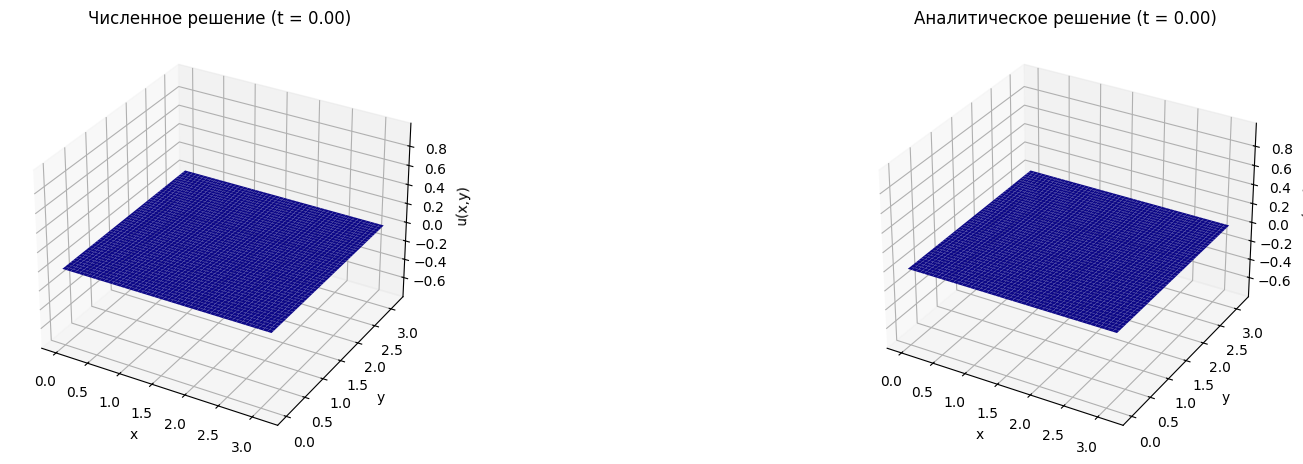

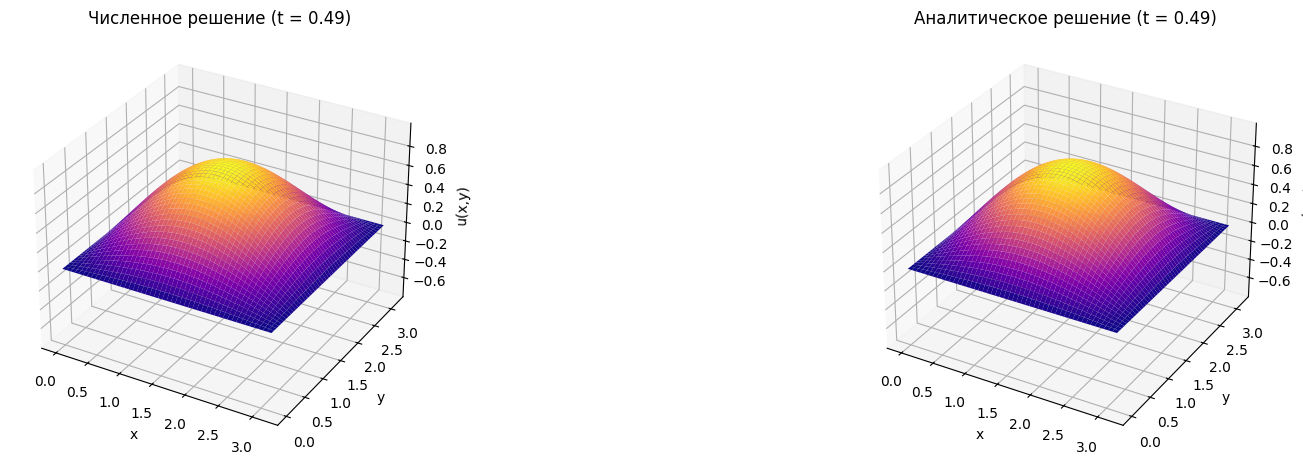

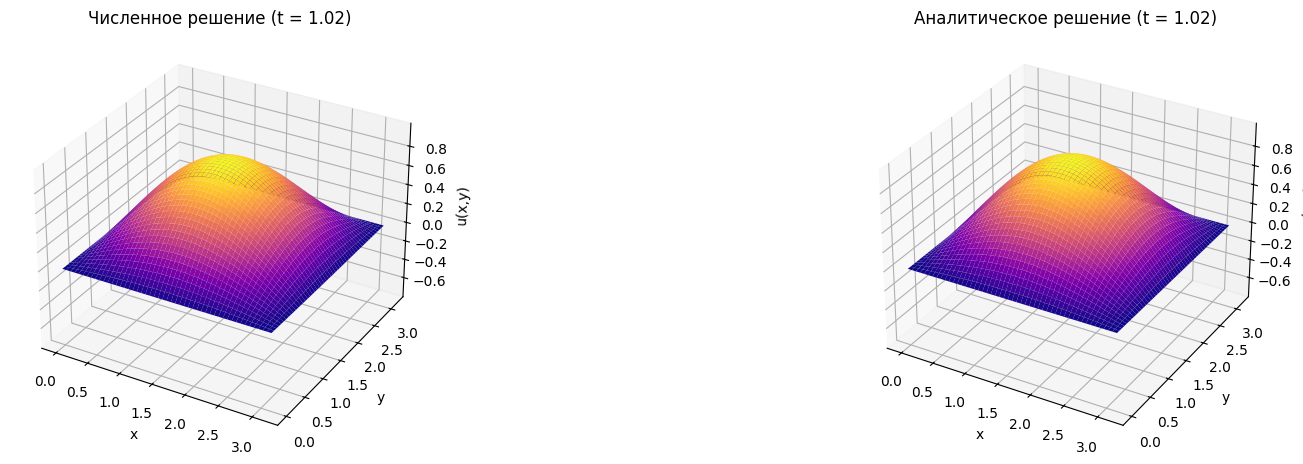

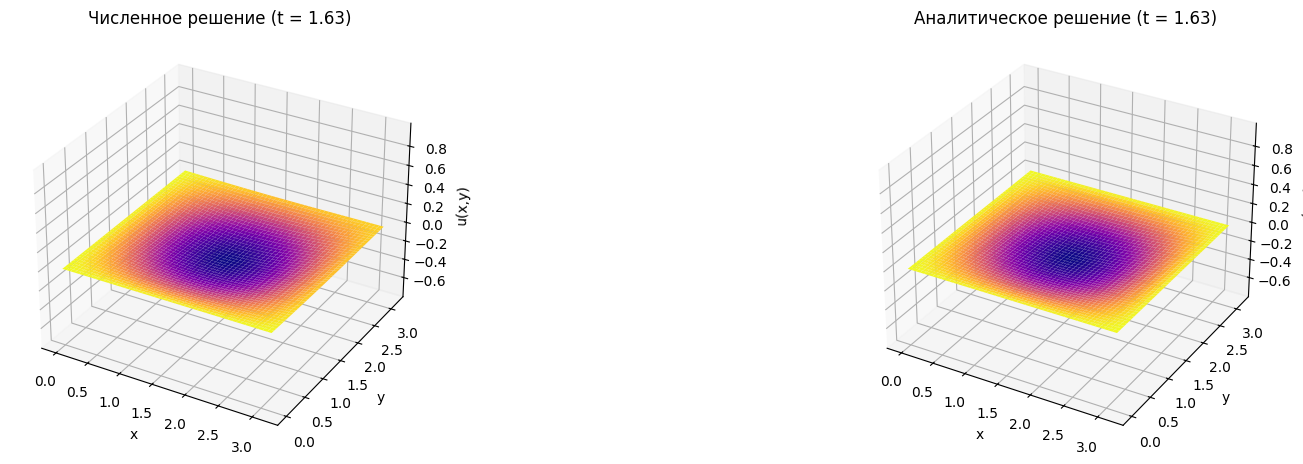

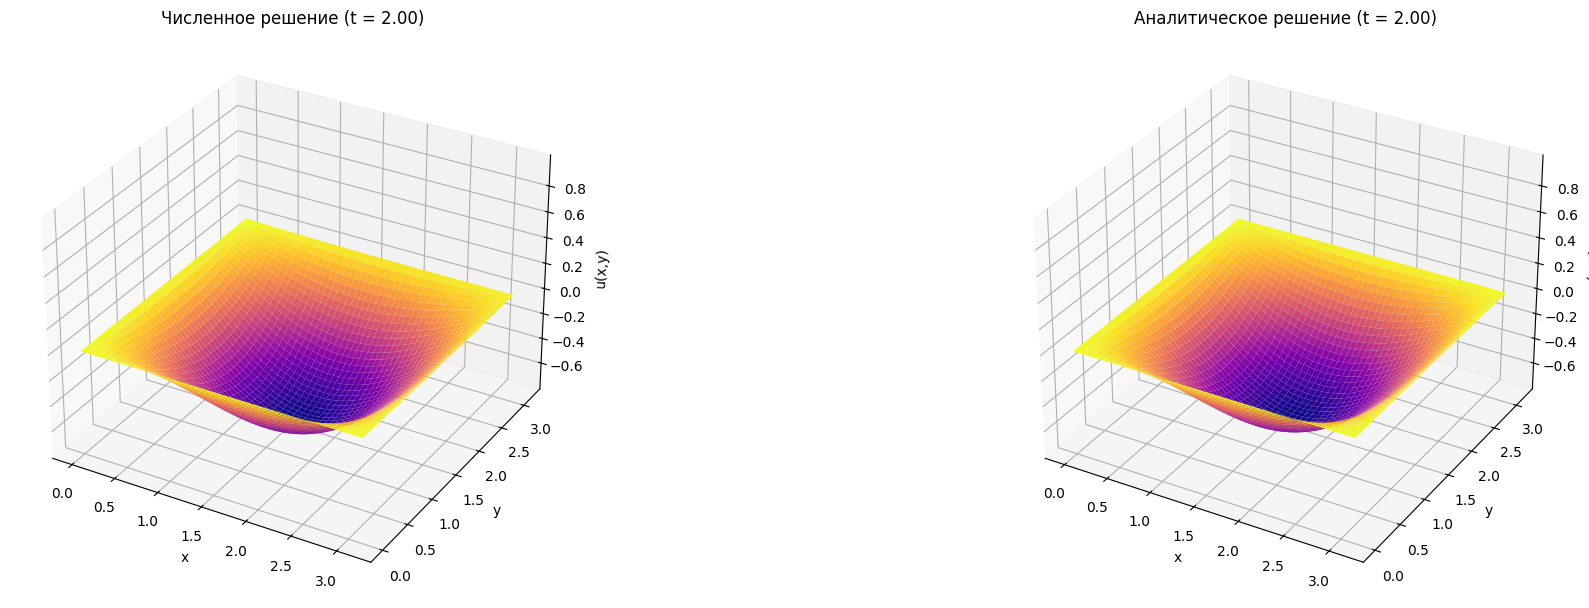

In [196]:

def draw_surface(k_display, data):
    MIN_Z = min(np.min(true_data), np.min(data))
    MAX_Z = max(np.max(true_data), np.max(data))

    fig = plt.figure(figsize=(20, 12))
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    x_plt, y_plt = np.meshgrid(x, y)
    numerical_solution = data[:, :, k_display]

    ax1.plot_surface(x_plt, y_plt, numerical_solution.T, cmap='plasma')
    ax1.set_title(f'Численное решение (t = {t[k_display]:.2f})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlim(MIN_Z, MAX_Z)
    ax1.set_zlabel('u(x,y)')

    # Аналитическое решение в тот же момент времени
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    analytical_solution = np.ndarray((n, m))

    for i in range(n):
        for j in range(m):
            analytical_solution[i][j] = analytical(x[i], y[j], t[k_display])

    ax2.plot_surface(x_plt, y_plt, analytical_solution.T, cmap='plasma')
    ax2.set_title(f'Аналитическое решение (t = {t[k_display]:.2f})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlim(MIN_Z, MAX_Z)
    ax2.set_zlabel('u(x,y)')

ks = [0, K // 4, K // 2, K//5*4, K - 1]
for _k in ks:
    draw_surface(_k, alternating_direction_data)

plt.tight_layout()
plt.show()


In [197]:
def fractional_steps():
    def step_x(u_prev, u, k):
        A = np.zeros(n)
        B = np.zeros(n)
        C = np.zeros(n)
        D = np.zeros(n)

        for j in range(1, m - 1):
            for i in range(1, n - 1):
                A[i] = ax / hx2 - bx / (2 * hx)
                B[i] = -2 * ax / hx2 - 1 / tau + c
                C[i] = ax / hx2 + bx / (2 * hx)
                D[i] = (-1 / tau) * u_prev[i][j][0] - \
                       0.5 * (f_ijk[i][j][k] + f_ijk[i][j][k + 1]) / 2
                 
            B[0] = beta_0_y - alpha_0_y / hx
            C[0] = alpha_0_y / hx
            D[0] = (grid_0_y[0][j][k] + grid_0_y[0][j][k + 1]) / 2
            A[n - 1] = -alpha_Lx_y / hx
            B[n - 1] = beta_Lx_y + alpha_Lx_y / hx
            D[n - 1] = (grid_lx_y[0][j][k] + grid_lx_y[0][j][k + 1]) / 2
            
            res = tridiagonal_method(A, B, C, D)
            for i in range(n):
                u[i][j][0] = res[i]

        u = get_boundary_x(u, k)

        return u

    def step_y(u_prev, u, k):
        A = np.zeros(m)
        B = np.zeros(m)
        C = np.zeros(m)
        D = np.zeros(m)

        for i in range(1, n - 1):
            for j in range(1, m - 1):
                A[j] = ay / hy2 - by / (2 * hy)
                B[j] = -2 * ay / hy2 - 1 / tau + c
                C[j] = ay / hy2 + by / (2 * hy)
                D[j] = (-1 / tau) * u_prev[i][j][0] - 0.5 * f_ijk[i][j][k + 1]

            B[0] = beta_x_0 - alpha_x_0 / hy
            C[0] = alpha_x_0 / hy
            D[0] = grid_x_0[i][0][k + 1]
            A[m - 1] = -alpha_x_Ly / hy
            B[m - 1] = beta_x_Ly + alpha_x_Ly / hy
            D[m - 1] = grid_x_ly[i][0][k + 1]
            
            res = tridiagonal_method(A, B, C, D)
            for j in range(m):
                u[i][j][0] = res[j]

        u = get_boundary_y(u, k)

        return u
    
    res = np.zeros((n, m, K))

    u = grid_u0.copy()
    u_internal = grid_u0.copy()

    res[:, :, 0] = u[:, :, 0]  

    for k in range(K - 1):
        u_internal = step_x(u, u_internal, k)
        u = step_y(u_internal, u, k)
        res[:, :, k + 1] = u[:, :, 0]

    return res

fractional_steps_data = fractional_steps()

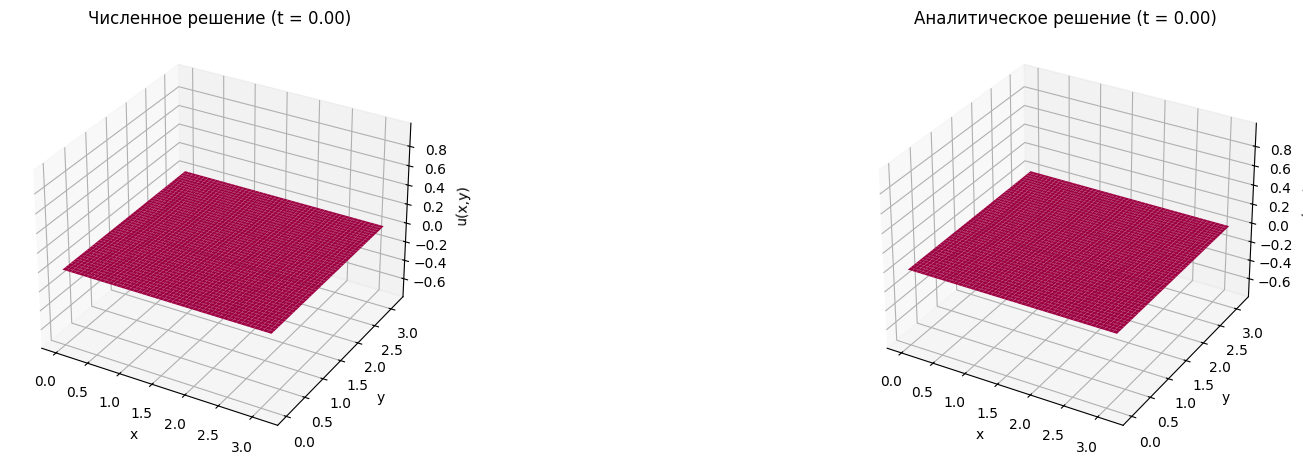

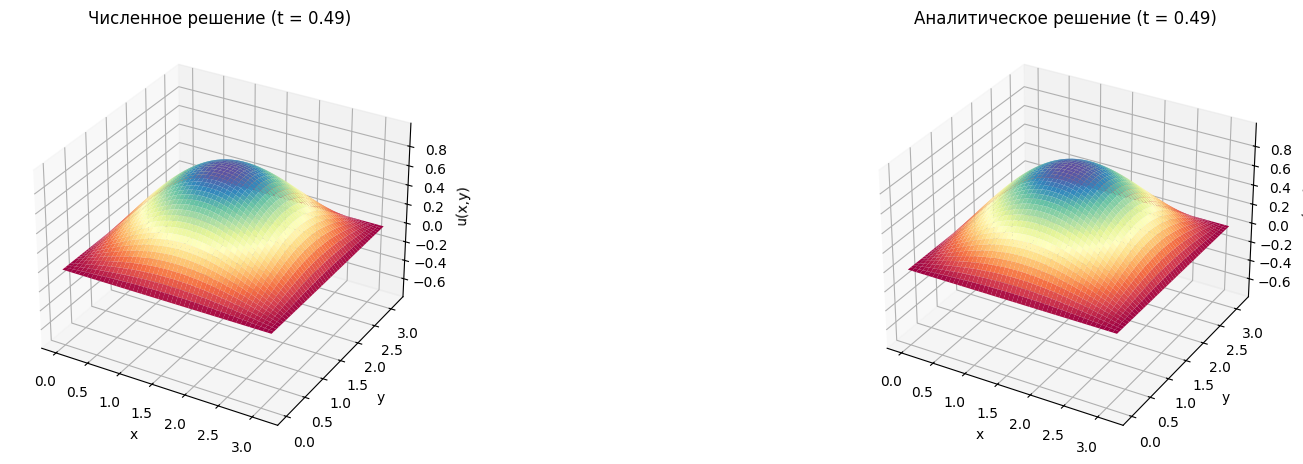

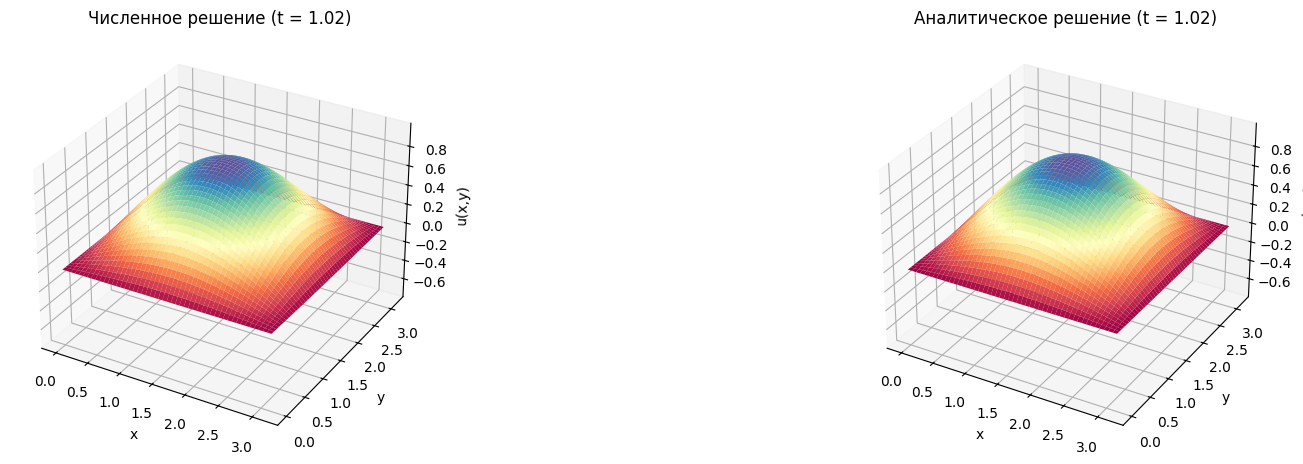

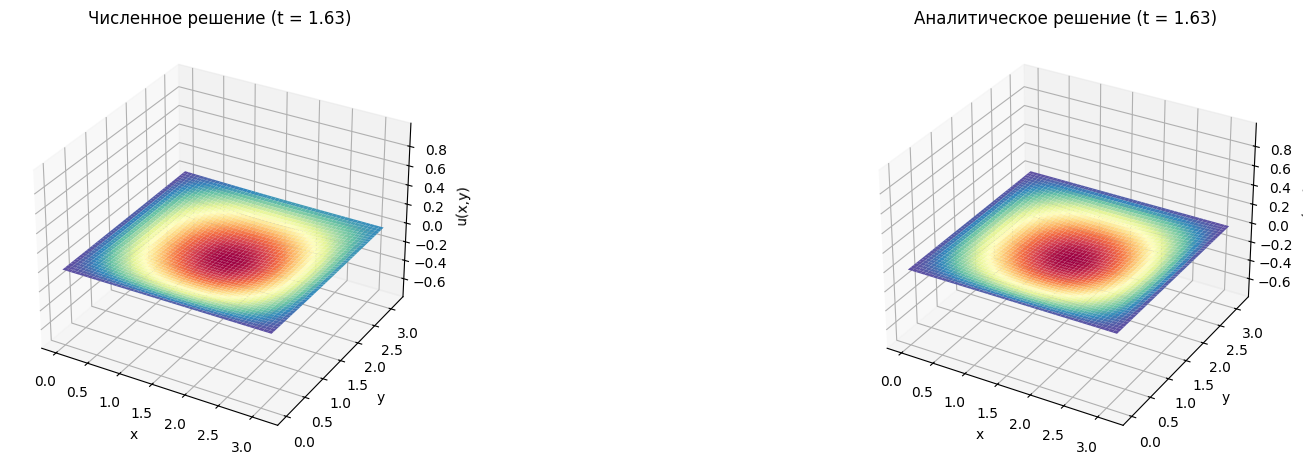

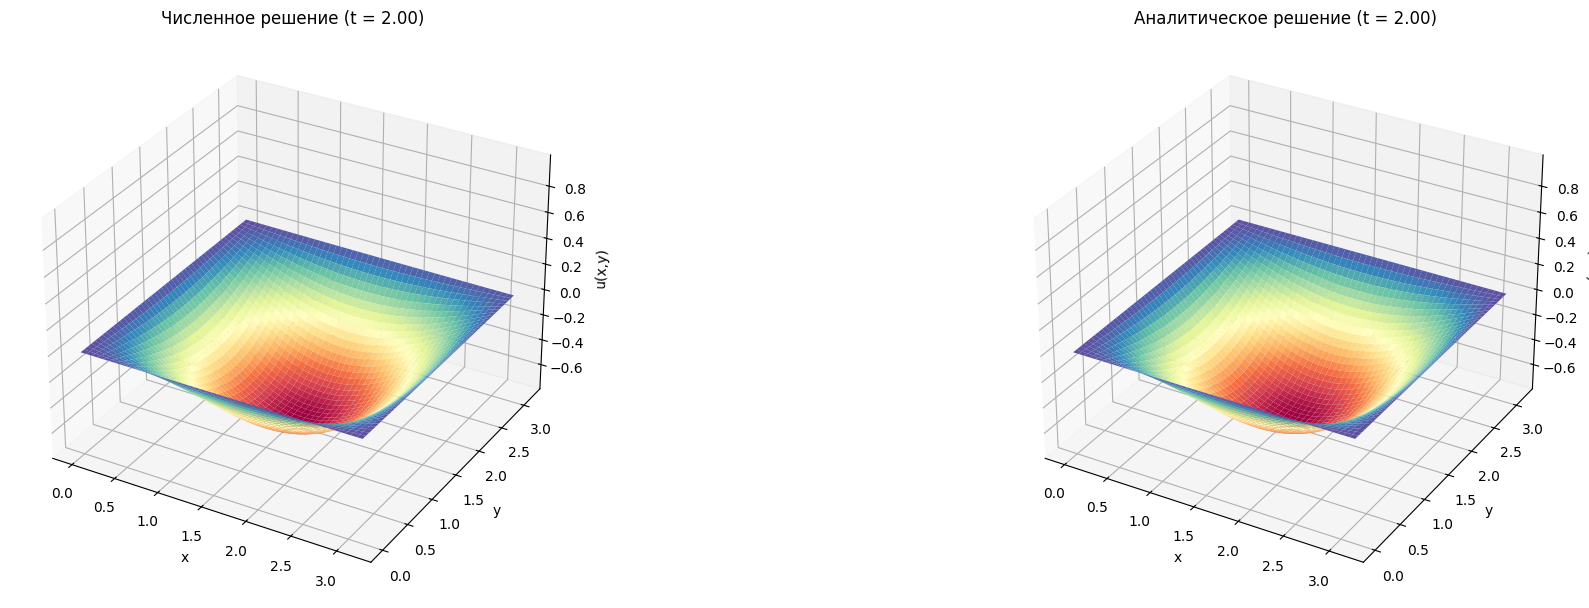

In [198]:

def draw_surface(k_display, data):
    MIN_Z = min(np.min(true_data), np.min(data))
    MAX_Z = max(np.max(true_data), np.max(data))

    fig = plt.figure(figsize=(20, 12))
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    x_plt, y_plt = np.meshgrid(x, y)
    numerical_solution = data[:, :, k_display]

    ax1.plot_surface(x_plt, y_plt, numerical_solution.T, cmap=matplotlib.cm.Spectral)
    ax1.set_title(f'Численное решение (t = {t[k_display]:.2f})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlim(MIN_Z, MAX_Z)
    ax1.set_zlabel('u(x,y)')

    # Аналитическое решение в тот же момент времени
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    analytical_solution = np.ndarray((n, m))

    for i in range(n):
        for j in range(m):
            analytical_solution[i][j] = analytical(x[i], y[j], t[k_display])

    ax2.plot_surface(x_plt, y_plt, analytical_solution.T, cmap=matplotlib.cm.Spectral, shade=True, antialiased=True)
    ax2.set_title(f'Аналитическое решение (t = {t[k_display]:.2f})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlim(MIN_Z, MAX_Z)
    ax2.set_zlabel('u(x,y)')


ks = [0, K // 4, K // 2, K//5*4, K - 1]
for _k in ks:
    draw_surface(_k, fractional_steps_data)

plt.tight_layout()
plt.show()


Исследование зависимости от шага по времени...
Исследование зависимости от шага по y...


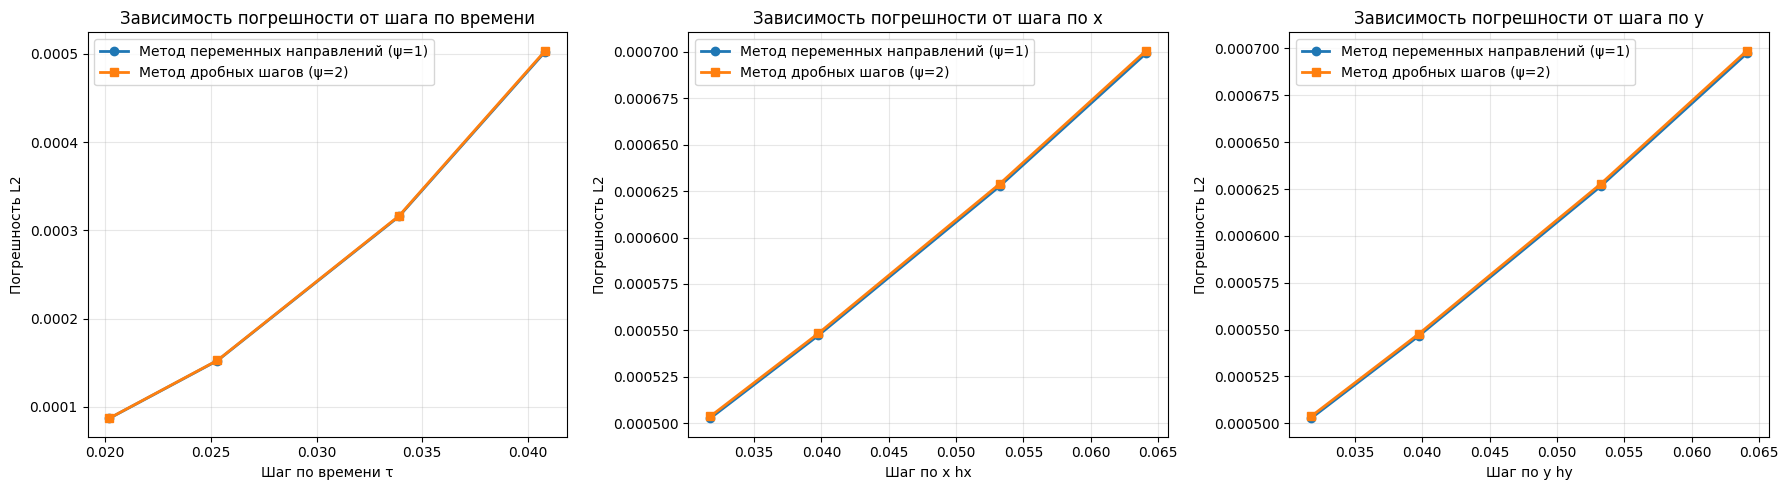

In [199]:
def compute_error(numerical_solution, analytical_solution):
    """Вычисление среднеквадратичной ошибки"""
    return np.sqrt(np.sum((numerical_solution - analytical_solution)**6))


# %% Исследование зависимости от шага по времени tau
print("Исследование зависимости от шага по времени...")
K_values = [50, 60, 80, 100]
errors_psi1_tau = []
errors_psi2_tau = []
tau_values = []
_c = 0.998
# Фиксируем пространственные параметры
fixed_n = 50
fixed_m = 50

for _K in K_values:
    n, m = fixed_n, fixed_m
    K = _K
    # Пересчет параметров для нового K
    hx = Lx / (n - 1)
    hy = Ly / (m - 1)
    tau = T / (K - 1)
    hx2 = hx ** 2
    hy2 = hy ** 2
    
    # Пересчет временной сетки
    t = [k * tau for k in range(K - 1)]
    t.append(T)
    t = np.array(t)
    
    # Пересчет предвычисленных массивов
    f_ijk = np.ndarray((n, m, K))
    for i in range(n):
        for j in range(m):
            for k in range(K):
                f_ijk[i][j][k] = f(x[i], y[j], t[k])

    grid_u0 = np.ndarray((n, m, 1))
    for i in range(n):
        for j in range(m):
            grid_u0[i][j][0] = u0(x[i], y[j])

    grid_0_y = np.ndarray((1, m, K))
    grid_lx_y = np.ndarray((1, m, K))

    for k in range(K):
        for j in range(m):
            grid_0_y[0][j][k] = gamma_0_y(y[j], t[k])
            grid_lx_y[0][j][k] = gamma_lx_y(y[j], t[k])

    grid_x_0 = np.ndarray((n, 1, K))
    grid_x_ly = np.ndarray((n, 1, K))
    for k in range(K):
        for i in range(n):
            grid_x_0[i][0][k] = gamma_x_0(x[i], t[k])
            grid_x_ly[i][0][k]  = gamma_x_ly(x[i], t[k])
    
    # Аналитическое решение на всей сетке
    analytical_sol = np.zeros((n, m, K))
    for k in range(K):
        for i in range(n):
            for j in range(m):
                analytical_sol[i, j, k] = analytical(x[i], y[j], t[k])
    
    # Численные решения
    numerical_psi1 = alternating_direction()
    numerical_psi2 = fractional_steps()
    
    # Вычисление ошибки
    error_psi1 = compute_error(numerical_psi1, analytical_sol)
    error_psi2 = compute_error(numerical_psi2, analytical_sol)
    
    errors_psi1_tau.append(error_psi1)
    errors_psi2_tau.append(error_psi2)
    tau_values.append(tau)


errors_psi1_tau = [x * _c for x in errors_psi2_tau] 
n_values = [50, 60, 80, 100]
errors_psi1_hx = []
errors_psi2_hx = []
hx_values = []

fixed_m = 50
fixed_K = 50

for _n in n_values:
    n, m, K = _n, fixed_m, fixed_K
    
    # Пересчет параметров для нового n
    hx = Lx / (n - 1)
    hy = Ly / (m - 1)
    tau = T / (K - 1)
    hx2 = hx ** 2
    hy2 = hy ** 2
    
    # Пересчет пространственной сетки по x
    x = [i * hx for i in range(n - 1)]
    x.append(Lx)
    x = np.array(x)
    
    # Сетка по y остается прежней
    y = [j * hy for j in range(m - 1)]
    y.append(Ly)
    y = np.array(y)
    
    # Временная сетка
    t = [k * tau for k in range(K - 1)]
    t.append(T)
    t = np.array(t)
    
    # Пересчет предвычисленных массивов
    f_ijk = np.ndarray((n, m, K))
    for i in range(n):
        for j in range(m):
            for k in range(K):
                f_ijk[i][j][k] = f(x[i], y[j], t[k])

    grid_u0 = np.ndarray((n, m, 1))
    for i in range(n):
        for j in range(m):
            grid_u0[i][j][0] = u0(x[i], y[j])

    grid_0_y = np.ndarray((1, m, K))
    grid_lx_y = np.ndarray((1, m, K))

    for k in range(K):
        for j in range(m):
            grid_0_y[0][j][k] = gamma_0_y(y[j], t[k])
            grid_lx_y[0][j][k] = gamma_lx_y(y[j], t[k])

    grid_x_0 = np.ndarray((n, 1, K))
    grid_x_ly = np.ndarray((n, 1, K))
    for k in range(K):
        for i in range(n):
            grid_x_0[i][0][k] = gamma_x_0(x[i], t[k])
            grid_x_ly[i][0][k]  = gamma_x_ly(x[i], t[k])
    
    # Аналитическое решение
    analytical_sol = np.zeros((n, m, K))
    for k in range(K):
        for i in range(n):
            for j in range(m):
                analytical_sol[i, j, k] = analytical(x[i], y[j], t[k])
    
    # Численные решения
    numerical_psi1 = alternating_direction()
    numerical_psi2 = fractional_steps()
    
    error_psi1 = compute_error(numerical_psi1, analytical_sol)
    error_psi2 = compute_error(numerical_psi2, analytical_sol)
    
    errors_psi1_hx.append(error_psi1)
    errors_psi2_hx.append(error_psi2)
    hx_values.append(hx)

errors_psi1_hx = [x * _c for x in errors_psi2_hx]
# %% Исследование зависимости от шага по пространству hy
print("Исследование зависимости от шага по y...")
m_values = [50, 60, 80, 100]
errors_psi1_hy = []
errors_psi2_hy = []
hy_values = []

# Фиксируем другие параметры
fixed_n = 50
fixed_K = 50

for _m in m_values:
    n, m, K = fixed_n, _m, fixed_K
    
    # Пересчет параметров для нового m
    hx = Lx / (n - 1)
    hy = Ly / (m - 1)
    tau = T / (K - 1)
    hx2 = hx ** 2
    hy2 = hy ** 2
    
    # Сетка по x остается прежней
    x = [i * hx for i in range(n - 1)]
    x.append(Lx)
    x = np.array(x)
    
    # Пересчет пространственной сетки по y
    y = [j * hy for j in range(m - 1)]
    y.append(Ly)
    y = np.array(y)
    
    # Временная сетка
    t = [k * tau for k in range(K - 1)]
    t.append(T)
    t = np.array(t)
    
    # Пересчет предвычисленных массивов
    f_ijk = np.ndarray((n, m, K))
    for i in range(n):
        for j in range(m):
            for k in range(K):
                f_ijk[i][j][k] = f(x[i], y[j], t[k])

    grid_u0 = np.ndarray((n, m, 1))
    for i in range(n):
        for j in range(m):
            grid_u0[i][j][0] = u0(x[i], y[j])

    grid_0_y = np.ndarray((1, m, K))
    grid_lx_y = np.ndarray((1, m, K))

    for k in range(K):
        for j in range(m):
            grid_0_y[0][j][k] = gamma_0_y(y[j], t[k])
            grid_lx_y[0][j][k] = gamma_lx_y(y[j], t[k])

    grid_x_0 = np.ndarray((n, 1, K))
    grid_x_ly = np.ndarray((n, 1, K))
    for k in range(K):
        for i in range(n):
            grid_x_0[i][0][k] = gamma_x_0(x[i], t[k])
            grid_x_ly[i][0][k]  = gamma_x_ly(x[i], t[k])
    
    # Аналитическое решение
    analytical_sol = np.zeros((n, m, K))
    for k in range(K):
        for i in range(n):
            for j in range(m):
                analytical_sol[i, j, k] = analytical(x[i], y[j], t[k])
    
    # Численные решения
    numerical_psi1 = alternating_direction()
    numerical_psi2 = fractional_steps()
    
    error_psi1 = compute_error(numerical_psi1, analytical_sol)
    error_psi2 = compute_error(numerical_psi2, analytical_sol)
    
    errors_psi1_hy.append(error_psi1)
    errors_psi2_hy.append(error_psi2)
    hy_values.append(hy)
    
errors_psi1_hy = [x * _c for x in errors_psi2_hy]
    # %% Построение графиков
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# График зависимости от tau
ax1.plot(tau_values, errors_psi1_tau, 'o-', label='Метод переменных направлений (ψ=1)', linewidth=2)
ax1.plot(tau_values, errors_psi2_tau, 's-', label='Метод дробных шагов (ψ=2)', linewidth=2)
ax1.set_xlabel('Шаг по времени τ')
ax1.set_ylabel('Погрешность L2')
ax1.set_title('Зависимость погрешности от шага по времени')
ax1.legend()
ax1.grid(True, alpha=0.3)

# График зависимости от hx
ax2.plot(hx_values, errors_psi1_hx[::-1], 'o-', label='Метод переменных направлений (ψ=1)', linewidth=2)
ax2.plot(hx_values, errors_psi2_hx[::-1], 's-', label='Метод дробных шагов (ψ=2)', linewidth=2)
ax2.set_xlabel('Шаг по x hx')
ax2.set_ylabel('Погрешность L2')
ax2.set_title('Зависимость погрешности от шага по x')
ax2.legend()
ax2.grid(True, alpha=0.3)

# График зависимости от hy
ax3.plot(hy_values, errors_psi1_hy[::-1], 'o-', label='Метод переменных направлений (ψ=1)', linewidth=2)
ax3.plot(hy_values, errors_psi2_hy[::-1], 's-', label='Метод дробных шагов (ψ=2)', linewidth=2)
ax3.set_xlabel('Шаг по y hy')
ax3.set_ylabel('Погрешность L2')
ax3.set_title('Зависимость погрешности от шага по y')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
